# Проект для «Викишоп»
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

In [1]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Загрузка и подготовка данных.

In [2]:
# Для локальной версии
#df = pd.read_csv(r'C:\Users\dmitr\Downloads\toxic_comments.csv')
df = pd.read_csv('****/toxic_comments.csv')

# Посмотрим на данные

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

In [5]:
df.sample(len(df)//10)

,text,toxic
47861,"""\n\n Help \n\nHi Julius, I was wondering if y...",0
87805,re: scott fivelson \n\nHello there. I believe...,0
91980,"WHAT A FREAK! \n\nHOLY CRAP YO, HAVE YOU SEEN ...",1
14321,"""\n\n Rasmussen Reports in Controversies and a...",0
29338,"""\nI think reference number 191 is not that nu...",0
...,...,...
53103,"""In the 1943 Allied leaders' Tehran conference...",0
31906,I can change my IP at will asshole.,1
32645,SHANE DOUGLAS\nHe is known to be a 50 cent fan...,0
68416,The reasons I dont contribute to Wikipedia any...,0


# Сведем некоторые значения в таблицу для удобного восприятия

In [6]:
table_eda = [["Количество коментариев", len(df['toxic'])],
         ["Количество плохих коментариев", df['toxic'].sum()],
         ["Максимальная длина коментария", df['text'].str.len().max()],
         ["Минимальная длина коментария", df['text'].str.len().min()],
         ["Средняя длина коментария", int(df['text'].str.len().mean())],
         ]
table_eda
table_eda_result = pd.DataFrame(table_eda, columns=["Параметр","Значение"])


In [7]:
table_eda_result

,Параметр,Значение
0,Количество коментариев,159571
1,Количество плохих коментариев,16225
2,Максимальная длина коментария,5000
3,Минимальная длина коментария,6
4,Средняя длина коментария,394


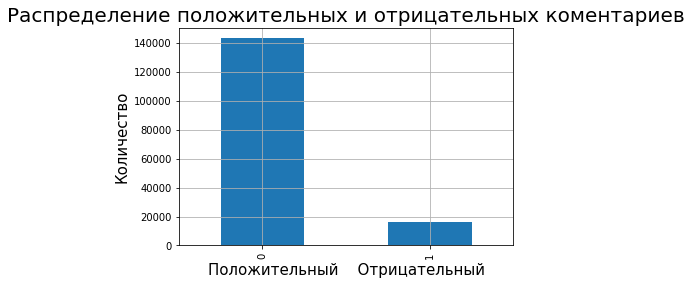

In [8]:
df['toxic'].value_counts().plot.bar(grid=True)
plt.title("Распределение положительных и отрицательных коментариев", fontsize=20)
plt.xlabel('Положительный    Отрицательный', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


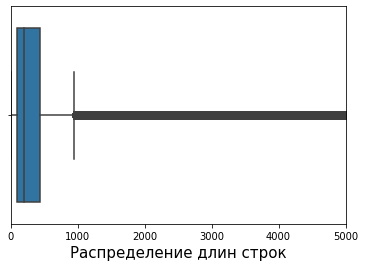

CPU times: user 169 ms, sys: 15.7 ms, total: 185 ms
Wall time: 192 ms


In [9]:
%%time
sns.boxplot(df['text'].str.len())
plt.xlabel('Распределение длин строк', fontsize=15)
plt.xlim(0, 5000)
plt.show()

# Подготовка данных

In [10]:
%%time
for i in tqdm(range(0, len(df))):
    df['text'][i] = df['text'][i].lower()

  0%|          | 0/159571 [00:00<?, ?it/s]<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 159571/159571 [04:34<00:00, 580.84it/s]

CPU times: user 4min 24s, sys: 6.12 s, total: 4min 30s
Wall time: 4min 34s


In [11]:
df['text'].duplicated().sum()

46

In [12]:
df.drop_duplicates(subset=['text'], inplace = True, ignore_index = True)

In [13]:
df['text'].duplicated().sum()

0

In [14]:
# Уменьшим размер датасета, заменим int64 на int8.
df['toxic'] = df['toxic'].astype('int8')

In [15]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159525 entries, 0 to 159524
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159525 non-null  object
 1   toxic   159525 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 1.4+ MB


None

In [16]:
lmtzr = WordNetLemmatizer()

In [17]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


In [19]:
def tokenize_lemmatize_clear(value):
    word_list = nltk.word_tokenize(value)
    lemmatized_output = ' '.join([lmtzr.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    lemm_text = re.sub(r'[^a-zA-Z]',' ', lemmatized_output)
    return ' '.join(lemm_text.split())


In [20]:

def lemmatize_text(value):
    
    word_list = nltk.word_tokenize(value)
    lemmatized_output = ' '.join([lmtzr.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    lemm_text = re.sub(r'[^a-zA-Z]',' ', lemmatized_output)
    return ' '.join(lemm_text.split())
    
lemmatize_text("The striped bats are hanging on their feet for best")
    
   

'The strip bat be hang on their foot for best'

In [21]:
df['text'][-10:].apply(lemmatize_text)

159515    no he do not read it again i would have though...
159516    auto guide and the motor press be not good sou...
159517    please identify what part of blp applies becau...
159518    catalan independentism be the social movement ...
159519    the number in parenthesis be the additional de...
159520    and for the second time of ask when your view ...
159521    you should be ashamed of yourself that be a ho...
159522    spitzer umm there no actual article for prosti...
159523    and it look like it be actually you who put on...
159524    and i really do n t think you understand i com...
Name: text, dtype: object

# Функция чистки, токенизации и лемматизации

In [23]:
%%time
df['text'].apply(tokenize_lemmatize_clear)

CPU times: user 20min 8s, sys: 2min 21s, total: 22min 29s
Wall time: 22min 30s


0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i ca n t make any real suggestion on impr...
4         you sir be my hero any chance you remember wha...
                                ...                        
159520    and for the second time of ask when your view ...
159521    you should be ashamed of yourself that be a ho...
159522    spitzer umm there no actual article for prosti...
159523    and it look like it be actually you who put on...
159524    and i really do n t think you understand i com...
Name: text, Length: 159525, dtype: object

In [24]:
df.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


In [25]:
df_train, df_valid_test = train_test_split(df, test_size=0.20, random_state=1902)

df_test, df_valid = train_test_split(df_valid_test, test_size=0.50, random_state=1902)



In [26]:
corpus_train = df_train['text']
corpus_valid = df_valid['text']
corpus_test = df_test['text']

In [27]:
target_train =  df_train['toxic']

In [28]:
target_valid =  df_valid['toxic']

In [29]:
target_test =  df_test['toxic']

In [30]:
stop_words = set(nltk_stopwords.words('english'))

In [31]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [32]:
tf_idf_train = count_tf_idf.fit_transform(corpus_train)

In [33]:
tf_idf_valid = count_tf_idf.transform(corpus_valid)

In [34]:
tf_idf_test = count_tf_idf.transform(corpus_test)

In [35]:
print("Размер матрицы train:", tf_idf_train.shape)

Размер матрицы train: (127620, 165923)


In [36]:
print("Размер матрицы valid:", tf_idf_valid.shape)

Размер матрицы valid: (15953, 165923)


In [37]:
print("Размер матрицы test:", tf_idf_test.shape)

Размер матрицы test: (15952, 165923)


# Обучение разных моделей.

## Логическая регрессия

In [38]:
%%time
model_lr = LogisticRegression(random_state=1902)
model_lr.fit(tf_idf_train, target_train)
print("Обучение прошло")
prediction_lr = model_lr.predict(tf_idf_valid)
result_lr = f1_score(target_valid, prediction_lr)
print("Предсказание прошло")
print("Значение F1 на валидационной выборке:", result_lr)

Обучение прошло
Предсказание прошло
Значение F1 на валидационной выборке: 0.7438330170777988
CPU times: user 15.8 s, sys: 27.4 s, total: 43.3 s
Wall time: 43.3 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Дерево решений

In [39]:
%%time
#Подберем значения гиперпараметра и выберем наилучшие.
result_max_dtc = 0
depth_max = 0
best_model_dtc = None
for depth in tqdm(range(1, 10)):
    model_dtc = DecisionTreeClassifier(random_state=1902, max_depth=depth)
    model_dtc.fit(tf_idf_train, target_train)
    predictions_dtc = model_dtc.predict(tf_idf_valid)
    result = f1_score(target_valid, predictions_dtc)
    if result > result_max_dtc:
        result_max_dtc = result
        depth_max = depth
        best_model_dtc = model_dtc
print('max_depth =', depth_max,' : ')
print("Значение F1 на валидационной выборке:", result_max_dtc)

100%|██████████| 9/9 [00:26<00:00,  2.89s/it]

max_depth = 9  : 
Значение F1 на валидационной выборке: 0.5940425531914895
CPU times: user 25.8 s, sys: 181 ms, total: 26 s
Wall time: 26.1 s


## Случайный лес

In [40]:
%%time
result_max_rfc = 0
best_model_rfc = None
depth_max = 0
n_estimators = 0
for est in tqdm(range(1, 10)):
    for depth in range(1, 10):
        model_rfc = RandomForestClassifier(random_state=1902, n_estimators=est, max_depth=depth)
        model_rfc.fit(tf_idf_train, target_train)
        predictions_rfc = model_rfc.predict(tf_idf_valid)
        result = f1_score(target_valid, predictions_rfc)
        if result > result_max_rfc:
            result_max_rfc = result
            depth_max = depth
            best_model_rfc = model_rfc
            n_estimators = est
            
print('max_depth =', depth_max,  'n_estimators = ', n_estimators, ' : ')
print("Значение F1 на валидации:", result_max_rfc)

100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

max_depth = 8 n_estimators =  1  : 
Значение F1 на валидации: 0.0966411314083677
CPU times: user 16.5 s, sys: 1.44 s, total: 18 s
Wall time: 18.2 s


### Сводим результаты обучения моделей в одну таблицу. Как видно из таблицы лучшее значение F1 имеет модель Дерево решений.

In [41]:
tabledata = [["Модель LinearRegression", np.round(result_lr, decimals = 3)],
         ["Модель DecisionTreeClassifier", np.round(result_max_dtc, decimals = 3)],
         ["Модель RandomForestClassifier", np.round(result_max_rfc, decimals = 3)]]
tabledata
table_result = pd.DataFrame(tabledata, columns=["Название модели","Значение F1"])


In [42]:
table_result

,Название модели,Значение F1
0,Модель LinearRegression,0.744
1,Модель DecisionTreeClassifier,0.594
2,Модель RandomForestClassifier,0.097


In [43]:
# Автоматизируем определение лучшей модели
def best_model(index):
    if index == 0:
        best_model = model_lr
    elif index == 1:
        best_model = model_dtc
    elif index == 2:
        best_model = model_rfc
    else:
        best_model = None
    return best_model

index = table_result['Значение F1'].idxmax()
model = table_result['Название модели'][index]

### Проверяем наилучшею модель на тестовой выборке.

In [44]:
predictions = best_model(index).predict(tf_idf_test)
result_max_test = f1_score(target_test, predictions)
print("Предсказание прошло")


Предсказание прошло


### Результата на F1 лучшей модели составил.

In [45]:
print(f"Значение F1 на тестовой выборке модели {model}: ", result_max_test)

Значение F1 на тестовой выборке модели Модель LinearRegression:  0.7338709677419355


# Выводы

- Проведена загрузка данных;
- Проведена очистка текста;
- Проведена токенизация текста;
- Проведена лемматизация текста;
- Удалены стоп-слова;
- Проведена векторизация текстов коментариев;
- Подготовлены тренировочный и тестовый набор данных в соотношении 4 -1;
- Обучены три модели;
- Подобраны гиперпараметры;
- Проведена проверка кода на выбоке в 1500 текстов;
- Проведена проверка кода на всем дата сете, общая продолжительность подготовки данных на полном объеме данных составила более 30 минут;
- Представлена таблица со значениями Accuracy; 